# Expectation-Maximization

Given a set of observations $X = \{x^{(1)}, x^{(2)}, ..., x^{(n)} \}$, a set of latent variables $Z = \{z^{(1)}, z^{(2)}, ..., z^{(n)} \}$, and a vector of unknown parameters $\theta$, we want to maximize likelihood function $P(X,Z;\theta)$. To do that, we can use EM-algorithm, which consists of two steps:

E-step:

$$Q_i = P\left(z^{(i)} | x^{(i)} ; \theta \right)$$

M-step:

$$\theta = \mathop{\arg\,\max}_\theta \sum_{i} \sum_{z^{(i)}} {Q_i(z^{(i)}) \log \frac{P(x^{(i)}, z^{(i)}; \theta)}{Q_i(z^{(i)})}}$$

Resources:
- [CS229 Video Lecture](https://www.youtube.com/watch?v=ZZGTuAkF-Hw)

In [287]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

from scipy import stats

sns.set()

## Generate random data

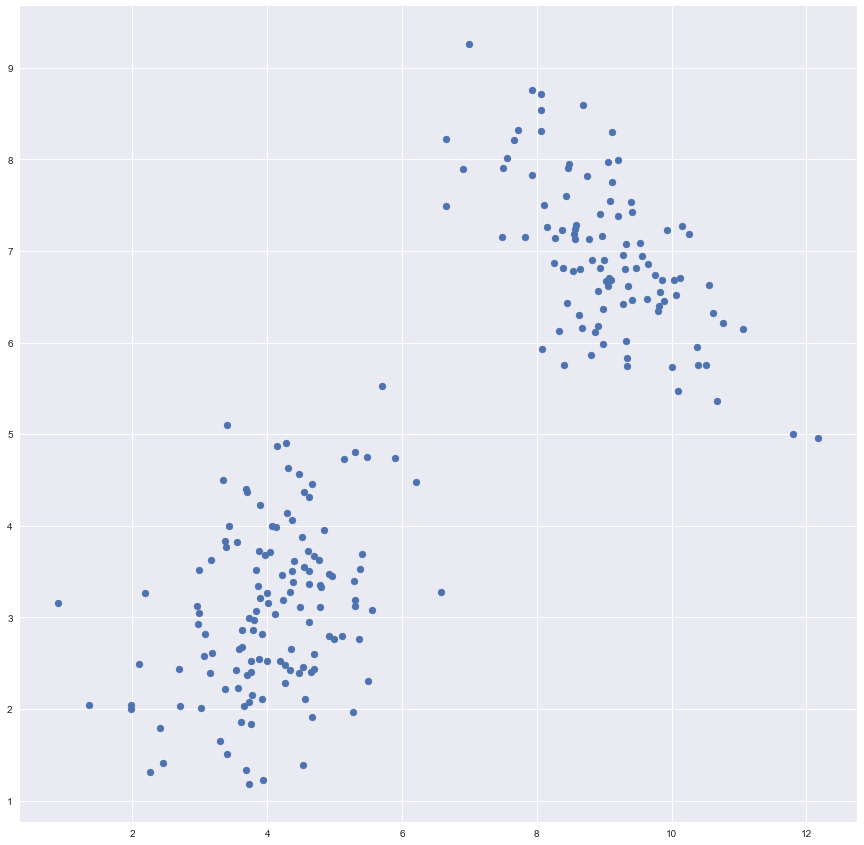

In [350]:
plt.figure(figsize=(15, 15))

component1 = np.random.multivariate_normal(
    np.array([4, 3]),
    np.array([[1, 0.3], [0.3, 1]]),
    130)
component2 = np.random.multivariate_normal(
    np.array([9, 7]),
    np.array([[1, -0.5], [-0.5, 1]]),
    100)
X_data = np.vstack([component1, component2])
np.random.shuffle(X_data)

plt.scatter(*X_data.T)

## Gaussian Mixture Model

In [348]:
class GaussianMixtureModel:

    def __init__(self):
        self.n_components = 0
        self.means = None
        self.covs = None
        self.priors = None

    def _init_weights(self, X, n_components):
        N, _ = X.shape

        self.n_components = n_components
        self.means = X[np.random.randint(N, size=n_components)]

        dists = np.sum(np.abs(X[:, np.newaxis, :] - self.means), axis=2)
        comps = np.argmin(dists, axis=1)

        self.covs = np.array([np.cov(X[comps==c].T)
                              for c in range(n_components)])

        self.priors = np.bincount(comps) / N

    def _get_probs(self, X):
        n_components = self.n_components

        probs = np.vstack([stats.multivariate_normal.pdf(X, mean, cov)
                           for mean, cov in zip(self.means, self.covs)])
        probs *= self.priors[:, np.newaxis]
        probs /= np.sum(probs, axis=0)

        return probs

    def fit(self, X, n_components=2, n_iters=100, log_period=5, log_enabled=True):
        self._init_weights(X, n_components)

        for i in range(n_iters):
            # E-step
            probs = self._get_probs(X)

            if log_enabled and i % log_period == 0:
                print('[%5d] Avg.prob: %.2f' % (i, np.max(probs, axis=0).mean()))

            # M-step
            prob_norm = np.sum(probs, axis=1)
            self.priors = np.mean(probs, axis=1)
            self.means = np.dot(probs, X) / prob_norm[:, np.newaxis]
            diff = X_data - self.means[:, np.newaxis, :]
            weighted_diff = probs[..., np.newaxis] * diff
            self.covs = (np.matmul(np.transpose(weighted_diff, axes=(0, 2, 1)), diff)
                         / prob_norm[:, np.newaxis, np.newaxis])

    def predict(self, X):
        X = np.reshape(X, (-1, X.shape[-1]))
        probs = self._get_probs(X)
        return np.argmax(probs, axis=0)

### Test on random data

In [351]:
model = GaussianMixtureModel()
model.fit(X_data, n_components=2)

[    0] Avg.prob: 1.00
[    5] Avg.prob: 1.00
[   10] Avg.prob: 1.00
[   15] Avg.prob: 1.00
[   20] Avg.prob: 1.00
[   25] Avg.prob: 1.00
[   30] Avg.prob: 1.00
[   35] Avg.prob: 1.00
[   40] Avg.prob: 1.00
[   45] Avg.prob: 1.00
[   50] Avg.prob: 1.00
[   55] Avg.prob: 1.00
[   60] Avg.prob: 1.00
[   65] Avg.prob: 1.00
[   70] Avg.prob: 1.00
[   75] Avg.prob: 1.00
[   80] Avg.prob: 1.00
[   85] Avg.prob: 1.00
[   90] Avg.prob: 1.00
[   95] Avg.prob: 1.00


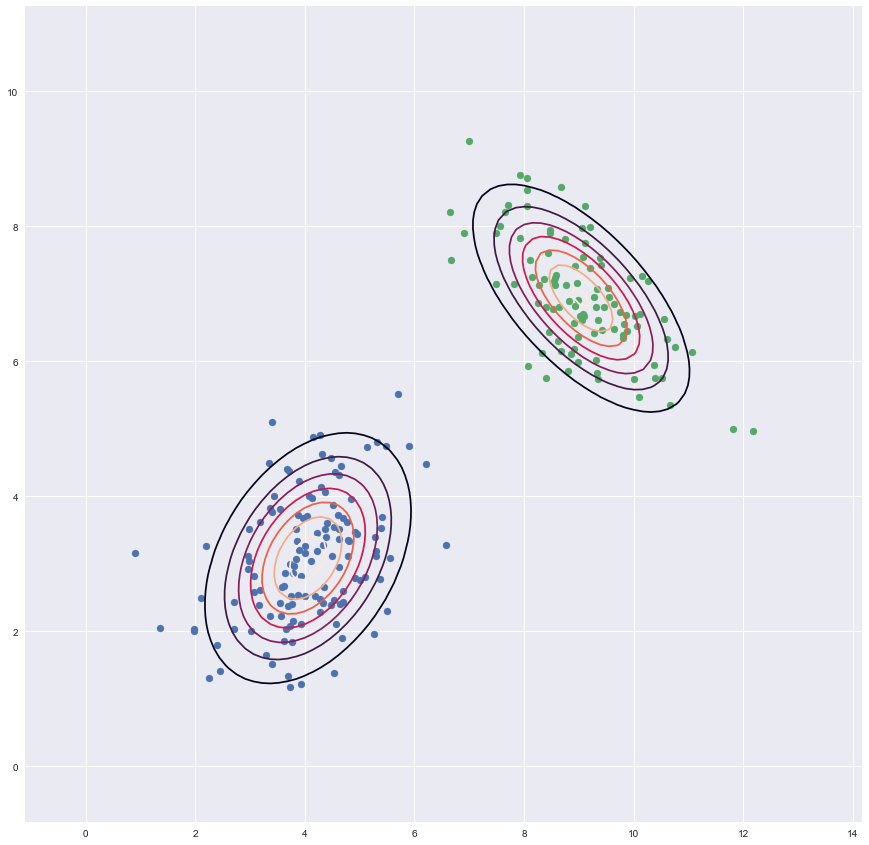

In [352]:
plt.figure(figsize=(15, 15))

min_x, min_y = np.min(X_data, axis=0)
max_x, max_y = np.max(X_data, axis=0)
padding_x, padding_y = 2, 2
X, Y = np.meshgrid(np.linspace(min_x - padding_x, max_x + padding_x, 100),
                   np.linspace(min_y - padding_y, max_y + padding_y, 100))

labels = model.predict(X_data)

for i, (mean, cov) in enumerate(zip(model.means, model.covs)):
    sigmax, sigmay = np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1])
    sigmaxy = cov[0, 1]
    mux, muy = mean
    Z = mlab.bivariate_normal(X, Y, sigmax=sigmax, sigmay=sigmay,
                              sigmaxy=sigmaxy, mux=mux, muy=muy) * model.priors[i]
    plt.scatter(*X_data[labels==i].T)
    plt.contour(X, Y, Z)